# Independent Plotting Assignment: Weather Phenomena in British Columbia

This assignment requires that you to find **at least** two datasets on the web which are related, and that you visualize these datasets to answer a question with the broad topic of **weather phenomena** (see below) for the region of **Vancouver, British Columbia, Canada**, or **Canada** more broadly.

Here are the assignment instructions:

 * You must state a question about the domain category and region that you identified as being interesting.
 * You must provide at least two links to available datasets. These could be links to files such as CSV or Excel files, or links to websites which might have data in tabular form, such as Wikipedia pages.
 * You must upload an image which addresses the research question you stated. In addition to addressing the question, this visual should follow Cairo's principles of truthfulness, functionality, beauty, and insightfulness.
 * You must contribute a short (1-2 paragraph) written justification of how your visualization addresses your stated research question.

## Wildfire data
### Source: 
    Original: https://catalogue.data.gov.bc.ca/dataset/fire-perimeters-historical#edc-pow
    Unnecessary columns were removed and the file was uloaded to Coursera's work env.
### Filter: 
    SIZE_HA >= 5.0

In [1]:
import pandas as pd
import numpy as np

with open('BC_WILDFIRES.csv') as f:
    df_fire = pd.read_csv(f, delimiter='\t', header=0, names=['fire_size', 'date', 'fire_area', 'fire_length'])

df_fire['date'] = pd.to_datetime((df_fire['date']), format='%Y%m%d')

#Filtering
MIN_SIZE = 5.0

Filter = True
Filter &= (df_fire['fire_size'] > MIN_SIZE) # minimum fire size
df_fire = df_fire[Filter]

# Sum the same-day fires to get a unique number for each day
df_fire = df_fire.groupby('date').sum()

# Log 10 fire sizes
df_fire['fire_hectares_log10'] = np.log10(df_fire['fire_size'])

print(df_fire.shape)
df_fire.head()

(6510, 4)


,fire_size,fire_area,fire_length,fire_hectares_log10
date,,,,
1917-07-21,368.7,3.687044e+06,11885.5132,2.566673
1918-05-09,87.6,8.769908e+05,4242.3611,1.942504
1918-06-28,69.2,6.920530e+05,3489.4806,1.840106
1918-09-23,64.7,6.472249e+05,5795.8880,1.810904
1919-04-18,198.9,1.989056e+06,10458.9134,2.298635


## Rainfall data
### Source: 
    Original: https://vancouver.weatherstats.ca/download.html
    Unnecessary columns were removed and the file was uloaded to Coursera's work env.

In [2]:
h=['date', 'humidity_min', 'humidity_max', 'temperature_min', 'temperature_max', 'precipitation']
with open('BC_WEATHER.csv') as f:
    df_weather = pd.read_csv(f, names=h, header=0)
    
df_weather['date'] = pd.to_datetime((df_weather['date']))

df_weather.dropna(inplace=True)
df_weather.set_index('date', inplace=True)

print(df_weather.shape)
df_weather.head()

(24055, 5)


,humidity_min,humidity_max,temperature_min,temperature_max,precipitation
date,,,,,
2019-11-03,71.02,93.92,4.86,11.00,5.69
2019-11-02,71.09,93.93,4.99,11.11,5.60
2019-11-01,70.98,93.94,5.10,11.21,5.58
2019-10-31,70.87,93.95,5.12,11.31,5.47
2019-10-30,70.79,93.97,5.21,11.44,5.35


# Merge Dataframes and Apply Date Cutoffs

In [3]:
# Get start and end date inclusive for both data frames
start_date = max(df_weather.index.min(), df_fire.index.min())
end_date = min(df_weather.index.max(), df_fire.index.max())

# Merge data frames and apply date limits
df = df_weather.merge(df_fire, right_index=True, left_index=True, sort=True)
df = df[(df.index >= start_date) & (df.index <= end_date)]

# Add seasons to dataframe
seasons = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
df['season'] = ((df.index.month%12 + 3)//3)
df['season'] = df['season'].map(seasons)


print(df.shape)
df.head()

(3593, 10)


,humidity_min,humidity_max,temperature_min,temperature_max,precipitation,fire_size,fire_area,fire_length,fire_hectares_log10,season
date,,,,,,,,,,
1954-03-01,72.47,96.80,1.32,8.77,2.92,1221.1,1.221184e+07,26596.3208,3.086751,Spring
1954-04-11,68.20,94.27,4.75,13.26,2.16,13.0,1.302099e+05,1326.0837,1.113943,Spring
1954-04-30,57.20,94.20,5.91,14.77,2.09,33.3,3.335027e+05,2913.2907,1.522444,Spring
1954-05-06,52.33,90.93,6.73,15.65,1.89,61.0,6.112852e+05,4943.2229,1.785330,Spring
1954-05-07,52.80,90.80,6.83,15.82,1.77,21.3,2.138322e+05,1886.3158,1.328380,Spring


# Plotting

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

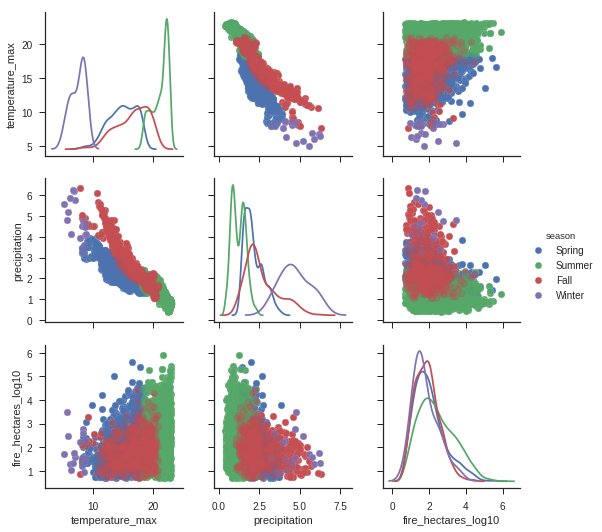

In [5]:
sns.set_style('ticks', {
    'figure.facecolor': 'white',   
    })

matrix_columns = ['temperature_max', 'precipitation', 'fire_hectares_log10']

pp = sns.pairplot(df, vars=matrix_columns, hue='season', diag_kind='kde')
pp = pp.map_offdiag(plt.scatter, alpha=0.3)


In [6]:
pp.savefig('assignment4.png', transparent=False, facecolor='w')